In [1]:
%load_ext autoreload
%autoreload 2

In [19]:
from CinePred.new_model import *
from CinePred.data.preprocessing import *
from CinePred.data.importing import import_data
from CinePred.data.featuring import add_inflation

from sklearn.model_selection import cross_val_score, GridSearchCV
from xgboost import XGBRegressor, plot_importance
from matplotlib import pyplot
import numpy as np

In [20]:
df = import_data('../raw_data/IMDb movies.csv')

In [21]:
df = keep_columns(df,
                      column_names=[
                          'year', 'date_published', 'genre', 'duration',
                          'budget', 'worlwide_gross_income',
                          'production_company', 'director', 'writer'
                      ])
df = remove_na_rows(df)

In [22]:
# date_published
df['date_published'] = convert_to_date(df[['date_published']])

# day of the year
df['date_sin'] = add_sin_features(df[['date_published']])
df['date_cos'] = add_cos_features(df[['date_published']])
df.drop(columns='date_published', inplace=True)

# year, duration
df['year'] = convert_to_int(df[['year']])
df['duration'] = convert_to_int(df[['duration']])

# genre
ohe = GenreOHE()
ohe.fit(df) # la colonne 'genre' est spécifié dans la classe
df = ohe.transform(df)

# budget
df['budget'] = convert_budget_column(df[['budget']])
df = df[df['budget'] != 0]
df = add_inflation(df, 'budget')
df['budget'] = log_transformation(df[['budget']])

# income
df['worlwide_gross_income'] = convert_income(df[['worlwide_gross_income']])
df = add_inflation(df, 'worlwide_gross_income')
df['worlwide_gross_income'] = log_transformation(df[['worlwide_gross_income']])

# cumsum
df = Add_Ones(df)
df = Add_number_of_movies_per_prod_company_in_Timeline(df)
df = Add_number_of_movies_per_directors_in_Timeline(df)
df = Add_number_of_movies_per_writer_in_Timeline(df)
df = Remove_Ones(df)

# sort & index:
df.sort_values('budget', inplace=True)
df.reset_index(inplace=True)
df.drop(columns=['index', 'production_company', 'director', 'writer'],
        inplace=True)

In [23]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [24]:
X = df.drop(columns=['worlwide_gross_income'])
y = df['worlwide_gross_income']
model = XGBRegressor(learning_rate=0.1, max_depth=2)

In [25]:
model.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=2, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

[0.02331384 0.02332367 0.57340395 0.         0.00531874 0.
 0.         0.         0.         0.         0.00480092 0.01578425
 0.01357207 0.         0.         0.         0.00731817 0.01374423
 0.00981499 0.00786122 0.         0.03150735 0.01205394 0.
 0.00508916 0.         0.06126088 0.1611686  0.02320979 0.00745424]


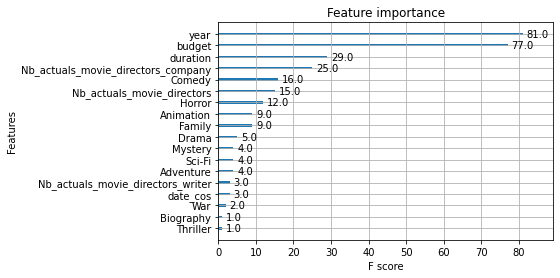

Index(['year', 'duration', 'budget', 'worlwide_gross_income', 'date_sin',
       'date_cos', 'History', 'Fantasy', 'Film-Noir', 'Romance', 'Documentary',
       'War', 'Horror', 'Adventure', 'Musical', 'Western', 'Crime', 'Sci-Fi',
       'Mystery', 'Family', 'Thriller', 'Music', 'Comedy', 'Animation',
       'Action', 'Biography', 'Sport', 'Drama',
       'Nb_actuals_movie_directors_company', 'Nb_actuals_movie_directors',
       'Nb_actuals_movie_directors_writer'],
      dtype='object')


In [26]:
print(model.feature_importances_)
plot_importance(model)
pyplot.show()
print(df.columns)